In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../../")
import toolbox

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# Read all test pdb names and the shifts that need to be excluded
all_test=toolbox.load_pkl("test_targets/test_200.pkl")
crazy_outlier_remove_H=[("1MI4A", 153)]
crazy_outlier_remove_CB=[("1DSBA", 30), ("2GYKE", 62)]
crazy_outlier_remove_N=[("1GOA",118),("1OVHA",1),("1D03A",1),("2IGD",1),("1VB0A",1),("1QOGA",1)]
param_remove=toolbox.load_pkl("test_targets/param_test.pkl")
cys_ox_remove=[("2GOOB",40),("2PF5A",47),("1DSBA",33),("1VKBA",35),("1VKBA",62),("2AFGB",117),("1LJUA",82),("1LJUA",89)] 
C_flip_remove=["1BGF_","1RPJA","2IDUA"]
HA_rc_remove=toolbox.load_pkl("test_targets/excluded_HA_RC.pkl")
PANAV_remove=toolbox.load_pkl("test_targets/PANAV_remove.pkl")
len(all_test)

200

In [12]:
dfs=[]
for name in all_test:
    dfs.append(pd.read_csv(f"test_targets/{name}.csv"))
df=pd.concat(dfs)

In [127]:
df.describe()

,RES_NUM,H,HA,C,CA,CB,N
count,23758.000000,19121.000000,11727.000000,8682.000000,13140.000000,10149.000000,15380.000000
mean,108.998821,8.280555,4.441892,175.948181,56.963772,38.080690,119.200068
std,141.126244,0.721037,0.542068,2.245100,4.858601,12.947423,5.868286
min,-2.000000,0.090000,1.100000,167.560000,42.300000,14.800000,26.570000
25%,36.000000,7.810000,4.090000,174.370000,54.470000,30.780000,116.275000
50%,72.000000,8.280000,4.400000,175.860000,57.205000,35.420000,119.535833
75%,130.000000,8.750000,4.770000,177.590000,59.970000,41.430000,122.662500
max,1169.000000,13.020000,6.690000,184.900000,69.610000,331.450000,152.990000


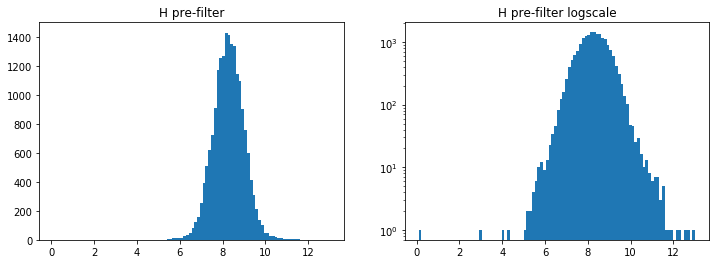

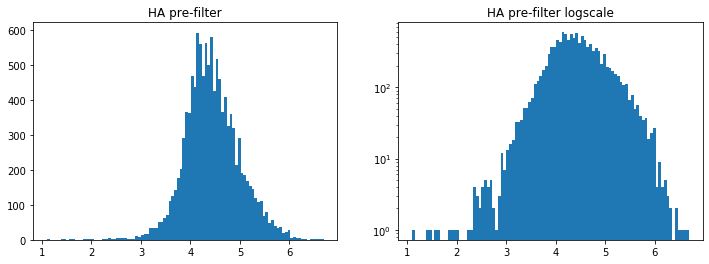

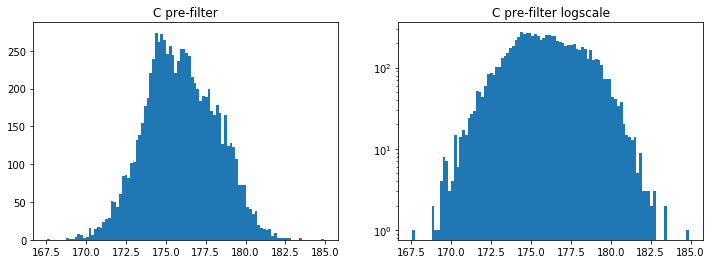

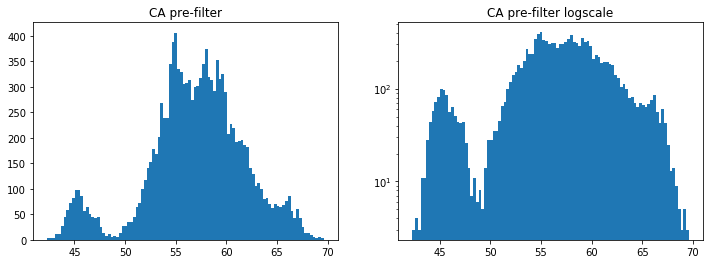

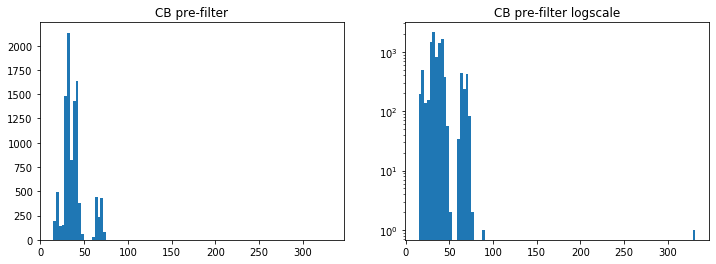

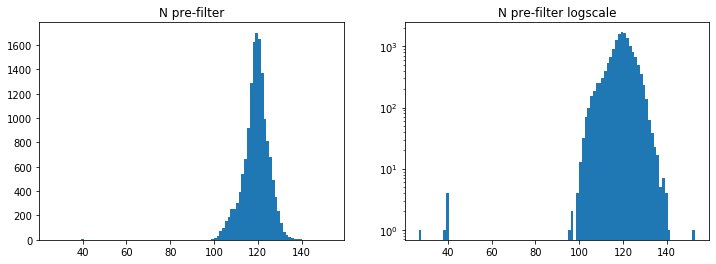

In [23]:
for atom in toolbox.ATOMS:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(df[atom],bins=100)
    plt.title(atom+" pre-filter")
    plt.subplot(1,2,2)
    plt.hist(df[atom],bins=100,log=True)
    plt.title(atom+" pre-filter logscale")

# Minimal curation
Only remove extremely erroneous chemical shifts, inconsistent CYS and anticorrelated carbons


In [53]:
df_minimal=df.copy()
# Remove extremely erroneous chemical shifts
df_minimal.loc[df_minimal.H<2,"H"]=np.nan
df_minimal.loc[df_minimal.CB>80,"CB"]=np.nan
df_minimal.loc[df_minimal.N<60,"N"]=np.nan
# Remove inconsistent CYS CB
df_minimal.loc[df_minimal.apply(lambda x:(x["FILE_ID"],x["RES_NUM"]) in cys_ox_remove,axis=1), "CB"]=np.nan
# Remove anticorrelated C
df_minimal.loc[df_minimal.apply(lambda x:x["FILE_ID"] in C_flip_remove, axis=1), "C"]=np.nan

In [126]:
df_minimal.describe()

,RES_NUM,H,HA,C,CA,CB,N
count,23758.000000,19120.000000,11727.000000,8327.000000,13140.000000,10139.000000,15374.000000
mean,108.998821,8.280983,4.441892,175.983469,56.963772,38.049005,119.232002
std,141.126244,0.718618,0.542068,2.236244,4.858601,12.609463,5.641515
min,-2.000000,3.030000,1.100000,167.560000,42.300000,14.800000,95.040000
25%,36.000000,7.810000,4.090000,174.400000,54.470000,30.780000,116.280000
50%,72.000000,8.280000,4.400000,175.890000,57.205000,35.420000,119.540000
75%,130.000000,8.750000,4.770000,177.617500,59.970000,41.430000,122.670000
max,1169.000000,13.020000,6.690000,184.900000,69.610000,76.780000,152.990000


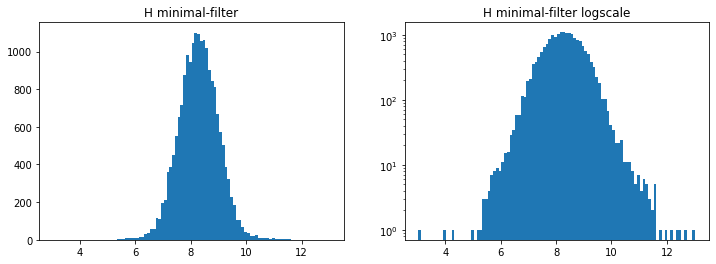

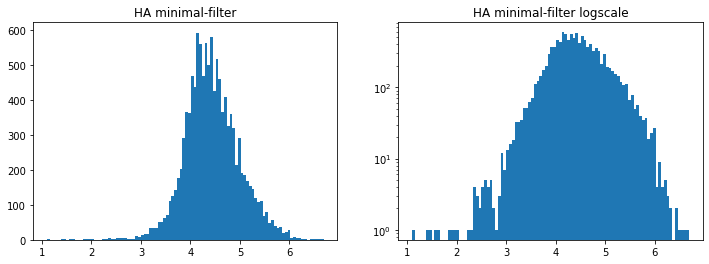

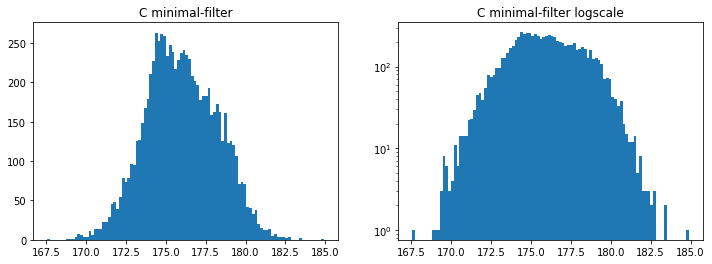

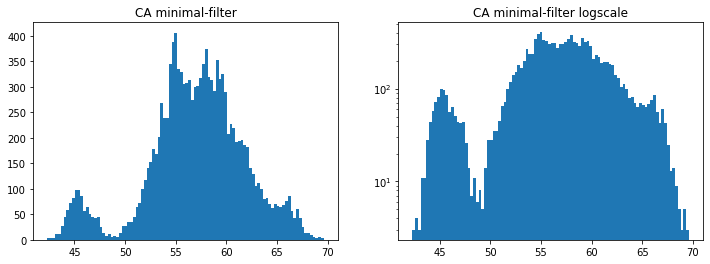

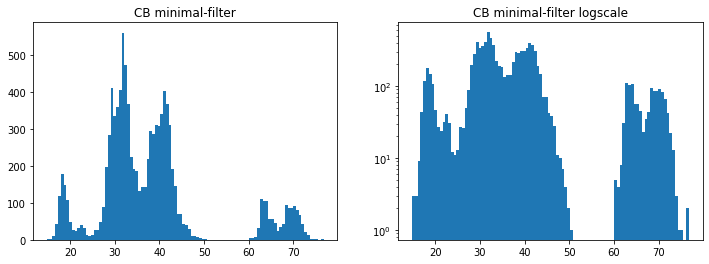

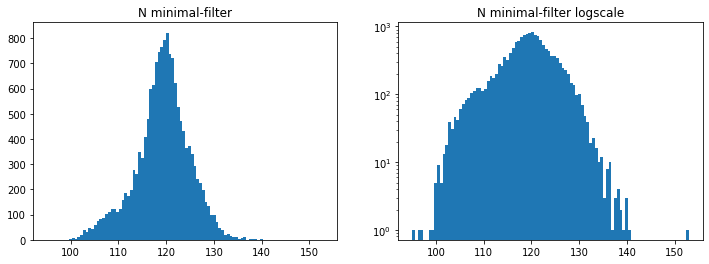

In [55]:
for atom in toolbox.ATOMS:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(df_minimal[atom],bins=100)
    plt.title(atom+" minimal-filter")
    plt.subplot(1,2,2)
    plt.hist(df_minimal[atom],bins=100,log=True)
    plt.title(atom+" minimal-filter logscale")


# More curation
additionally remove paramagnetic proteins, H-alpha with too large ring current, and PANAV outliers

In [122]:
df_curated=df_minimal.copy()
# Remove paramagnetic proteins: all shifts
df_curated.loc[df_curated.apply(lambda x:x["FILE_ID"] in param_remove, axis=1),toolbox.ATOMS]=np.nan
# Remove HA with too large ring current
df_curated.loc[df_curated.apply(lambda x:((x["FILE_ID"]+"_")[:5],x["RES_NUM"],x["RESNAME"]) in HA_rc_remove,axis=1), "HA"]=np.nan
# Remove PANAV outliers
for item in PANAV_remove:
    id,resnum,resname,atom=item
    if id[-1]=="_":
        id=id[:4]
    df_curated.loc[(df_curated.FILE_ID==id)&(df_curated.RES_NUM==resnum)&(df_curated.RESNAME==resname),atom]=np.nan

In [128]:
df_curated.describe()

,RES_NUM,H,HA,C,CA,CB,N
count,23758.000000,18848.000000,11487.000000,7954.000000,12533.000000,9883.000000,14741.000000
mean,108.998821,8.282899,4.451241,176.015974,56.925129,38.070058,119.285774
std,141.126244,0.698004,0.527520,2.198127,4.833013,12.611347,5.541215
min,-2.000000,5.570000,2.505000,169.050000,42.300000,14.800000,99.160000
25%,36.000000,7.810000,4.100000,174.440000,54.450000,30.810000,116.350000
50%,72.000000,8.287500,4.410000,175.920000,57.160000,35.460000,119.590000
75%,130.000000,8.755000,4.780000,177.610000,59.930000,41.430000,122.680000
max,1169.000000,11.546667,6.690000,182.790000,69.610000,74.953333,140.540000


/home/jerry/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jerry/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


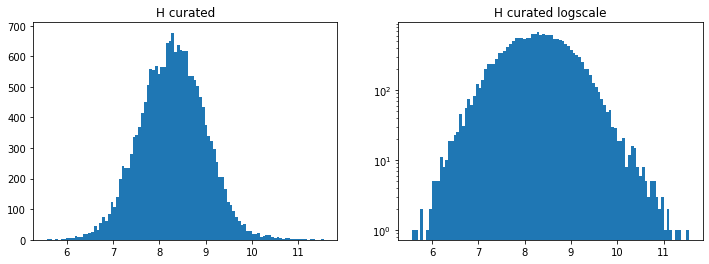

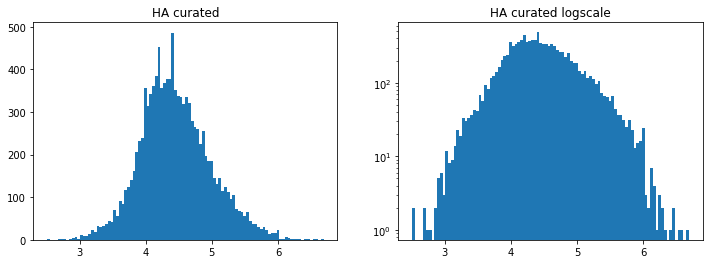

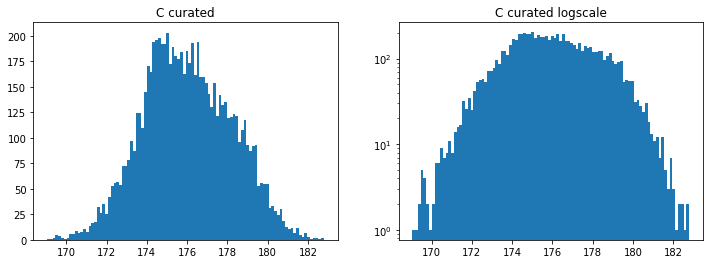

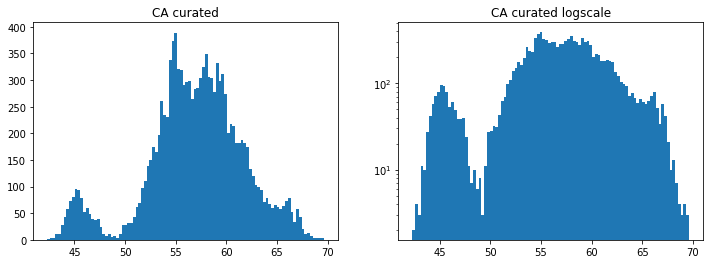

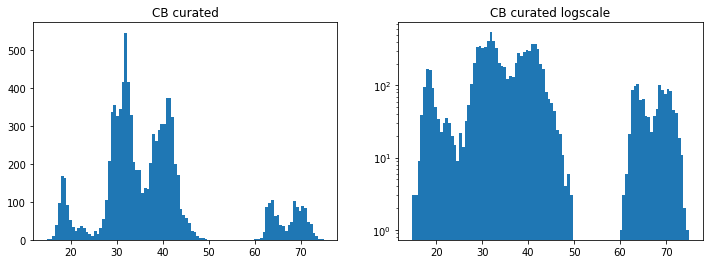

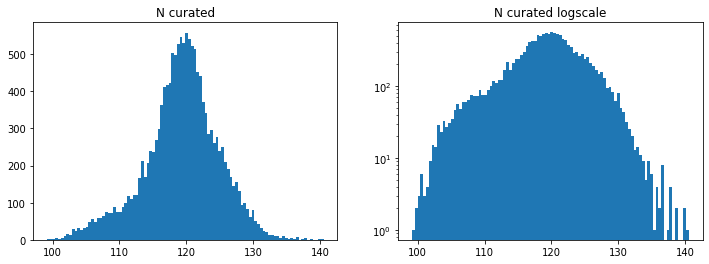

In [129]:
for atom in toolbox.ATOMS:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(df_curated[atom],bins=100)
    plt.title(atom+" curated")
    plt.subplot(1,2,2)
    plt.hist(df_curated[atom],bins=100,log=True)
    plt.title(atom+" curated logscale")